In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
import numpy as np
import pandas as pd
#plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
#machine learning et Méthodes statistiques
import statsmodels.api as sm
#Désactiver les avertissements inutiles si nécessaire
import warnings

In [3]:
# importation de base des donneés de 2019-01-01 00:00:00 à 2022-11-29 12:45:00 
import CreationDatacopie as cr
df = cr.dataframe('Consommation (MW)')

le nombre de NaN sur data2019 est :  0
le nombre de NaN sur data2020 est :  0
le nombre de NaN sur data2021 est :  0
le nombre de NaN sur data2022HALF1 est :  0
le nombre de NaN sur data2022HALF2 est :  0


In [4]:
df.head(3)

,Consommation (MW)
Temps,
2019-01-01 00:00:00,64207.0
2019-01-01 00:15:00,63684.5
2019-01-01 00:30:00,63162.0


In [5]:
df.tail(3)

,Consommation (MW)
Temps,
2022-11-30 07:15:00,62280.0
2022-11-30 07:30:00,63684.0
2022-11-30 07:45:00,64332.0


<AxesSubplot:xlabel='Temps'>

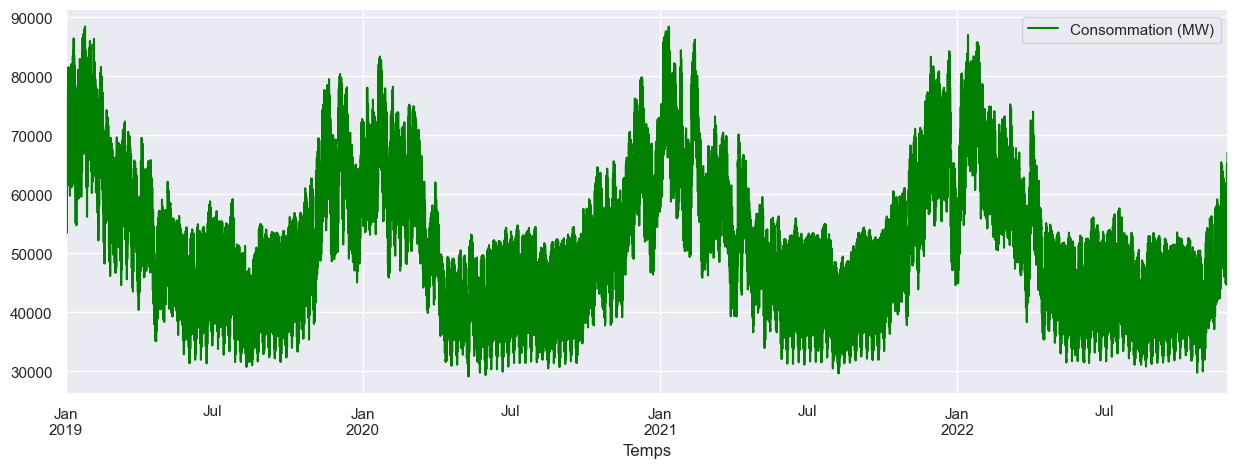

In [6]:
df.plot(figsize=(15,5),xlabel='Temps',color='green')

In [7]:
## Diviser les données en data test et data train 
data_test = df.iloc[-35880:,:].copy() # 20%
data_train = df.iloc[:-35880].copy()  # 80%

In [8]:
#Unobserved Components model definition
model_UC1 = sm.tsa.UnobservedComponents(df,
                                        level='dtrend',
                                        irregular=True,
                                        stochastic_level = False,
                                        stochastic_trend = False,
                                        stochastic_freq_seasonal = [False, False, False],
                                        freq_seasonal=[{'period': 672, 'harmonics': 1},
                                                       {'period': 2880, 'harmonics': 1},
                                                       {'period': 35066, 'harmonics': 2}])

/Users/maryam/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/structural.py:426: SpecificationWarning: Value of `irregular` may be overridden when the trend component is specified using a model string.
  warn("Value of `%s` may be overridden when the trend"
/Users/maryam/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)


In [9]:
# essayage du modèle aux données du train data
model_UC1res = model_UC1.fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.81162D+01    |proj g|=  1.31686D-02

At iterate    5    f=  1.08720D+01    |proj g|=  8.00713D-04

At iterate   10    f=  1.01903D+01    |proj g|=  1.24768D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1     11     15      1     0     0   2.536D-06   1.019D+01
  F =   10.188945425121833     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [10]:
#print statsmodels summary pour le modèle 
print(model_UC1res.summary())

                            Unobserved Components Results                            
Dep. Variable:             Consommation (MW)   No. Observations:               137216
Model:                   deterministic trend   Log Likelihood            -1398086.335
                     + freq_seasonal(672(1))   AIC                        2796174.671
                    + freq_seasonal(2880(1))   BIC                        2796184.500
                   + freq_seasonal(35066(2))   HQIC                       2796177.612
Date:                       Fri, 02 Dec 2022                                         
Time:                               10:05:16                                         
Sample:                           01-01-2019                                         
                                - 11-30-2022                                         
Covariance Type:                         opg                                         
                       coef    std err          z     

In [11]:
#modèle de prédiction 
forecast_UC1 = model_UC1res.forecast(steps=35880)


In [12]:
#calculating mean absolute error and root mean squared error for out-of-sample prediction for model evaluation
error = np.sqrt(np.mean([(data_test.iloc[x,:] - forecast_UC1[x]) ** 2 for x in range(len(forecast_UC1))]))      
print(f"Out-of-sample root mean squared error (RMSE): {'%.0f' % error}")

Out-of-sample root mean squared error (RMSE): 8385


# 1-Pour tester la validation du modèle :

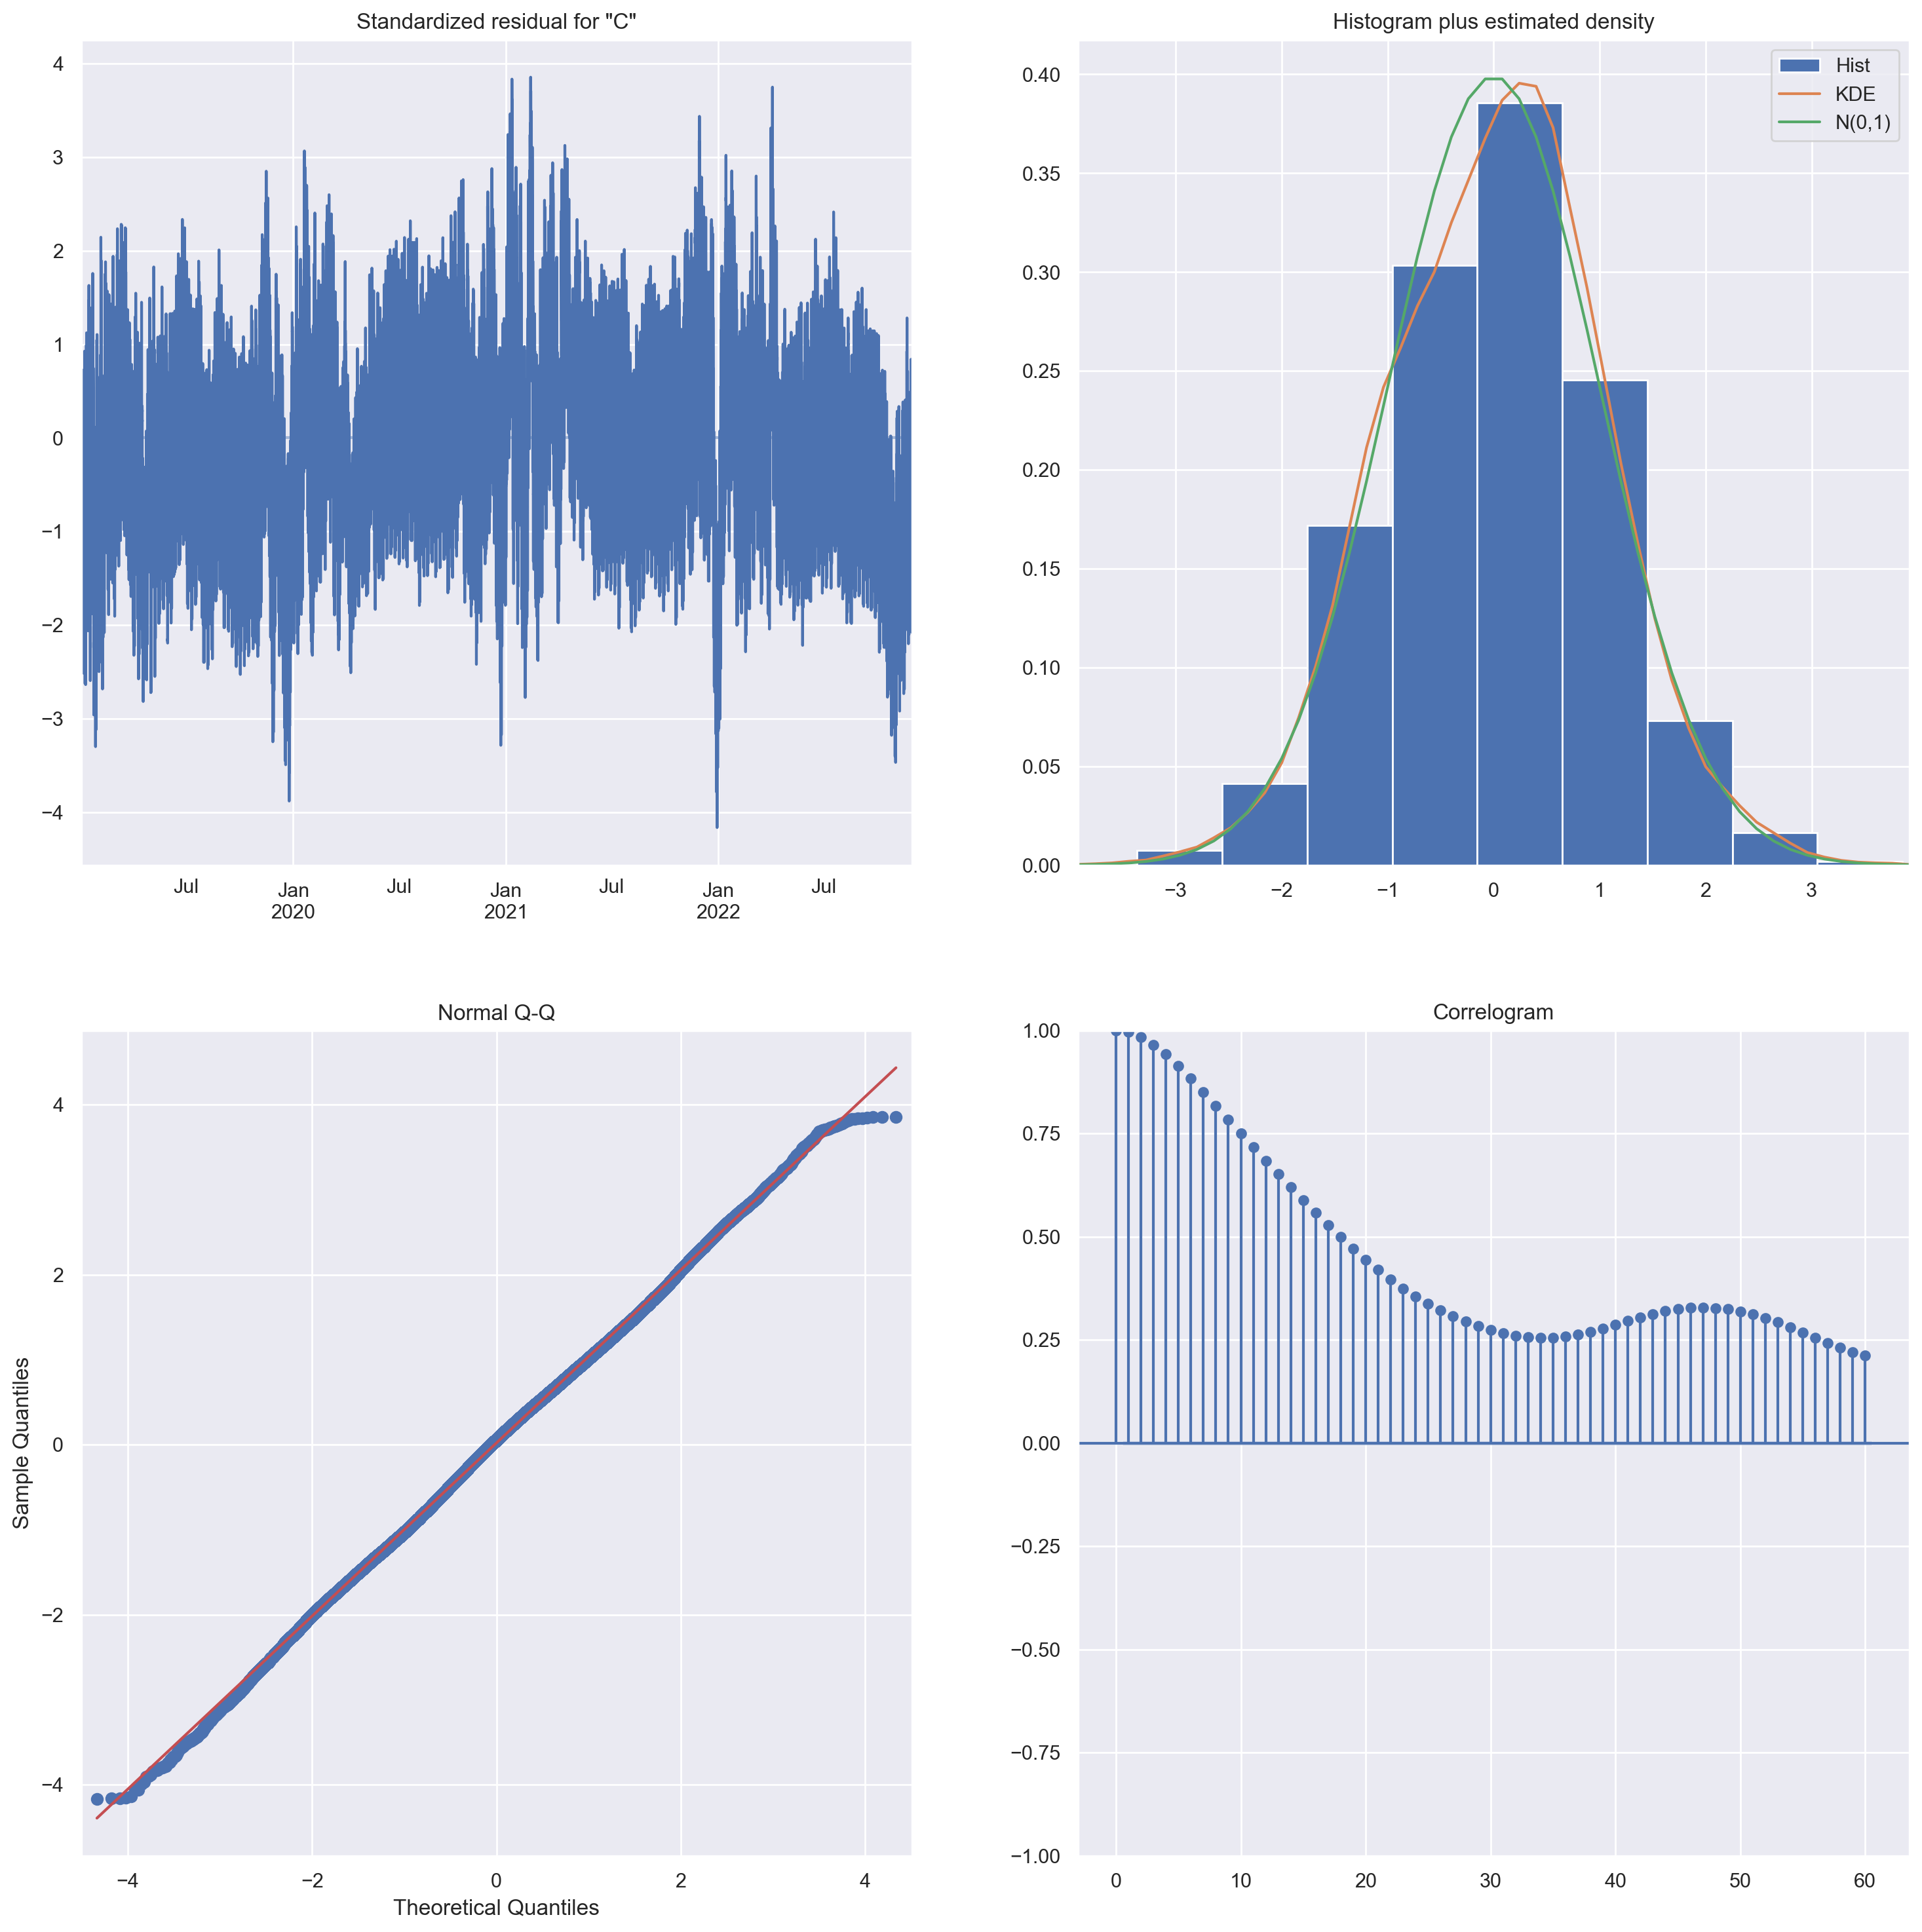

In [13]:
# Tracé les diagnostics résiduels du modèle Unobserved Components
model_UC1res.plot_diagnostics(figsize=(18,18),lags=60).set_dpi(200);
plt.show();

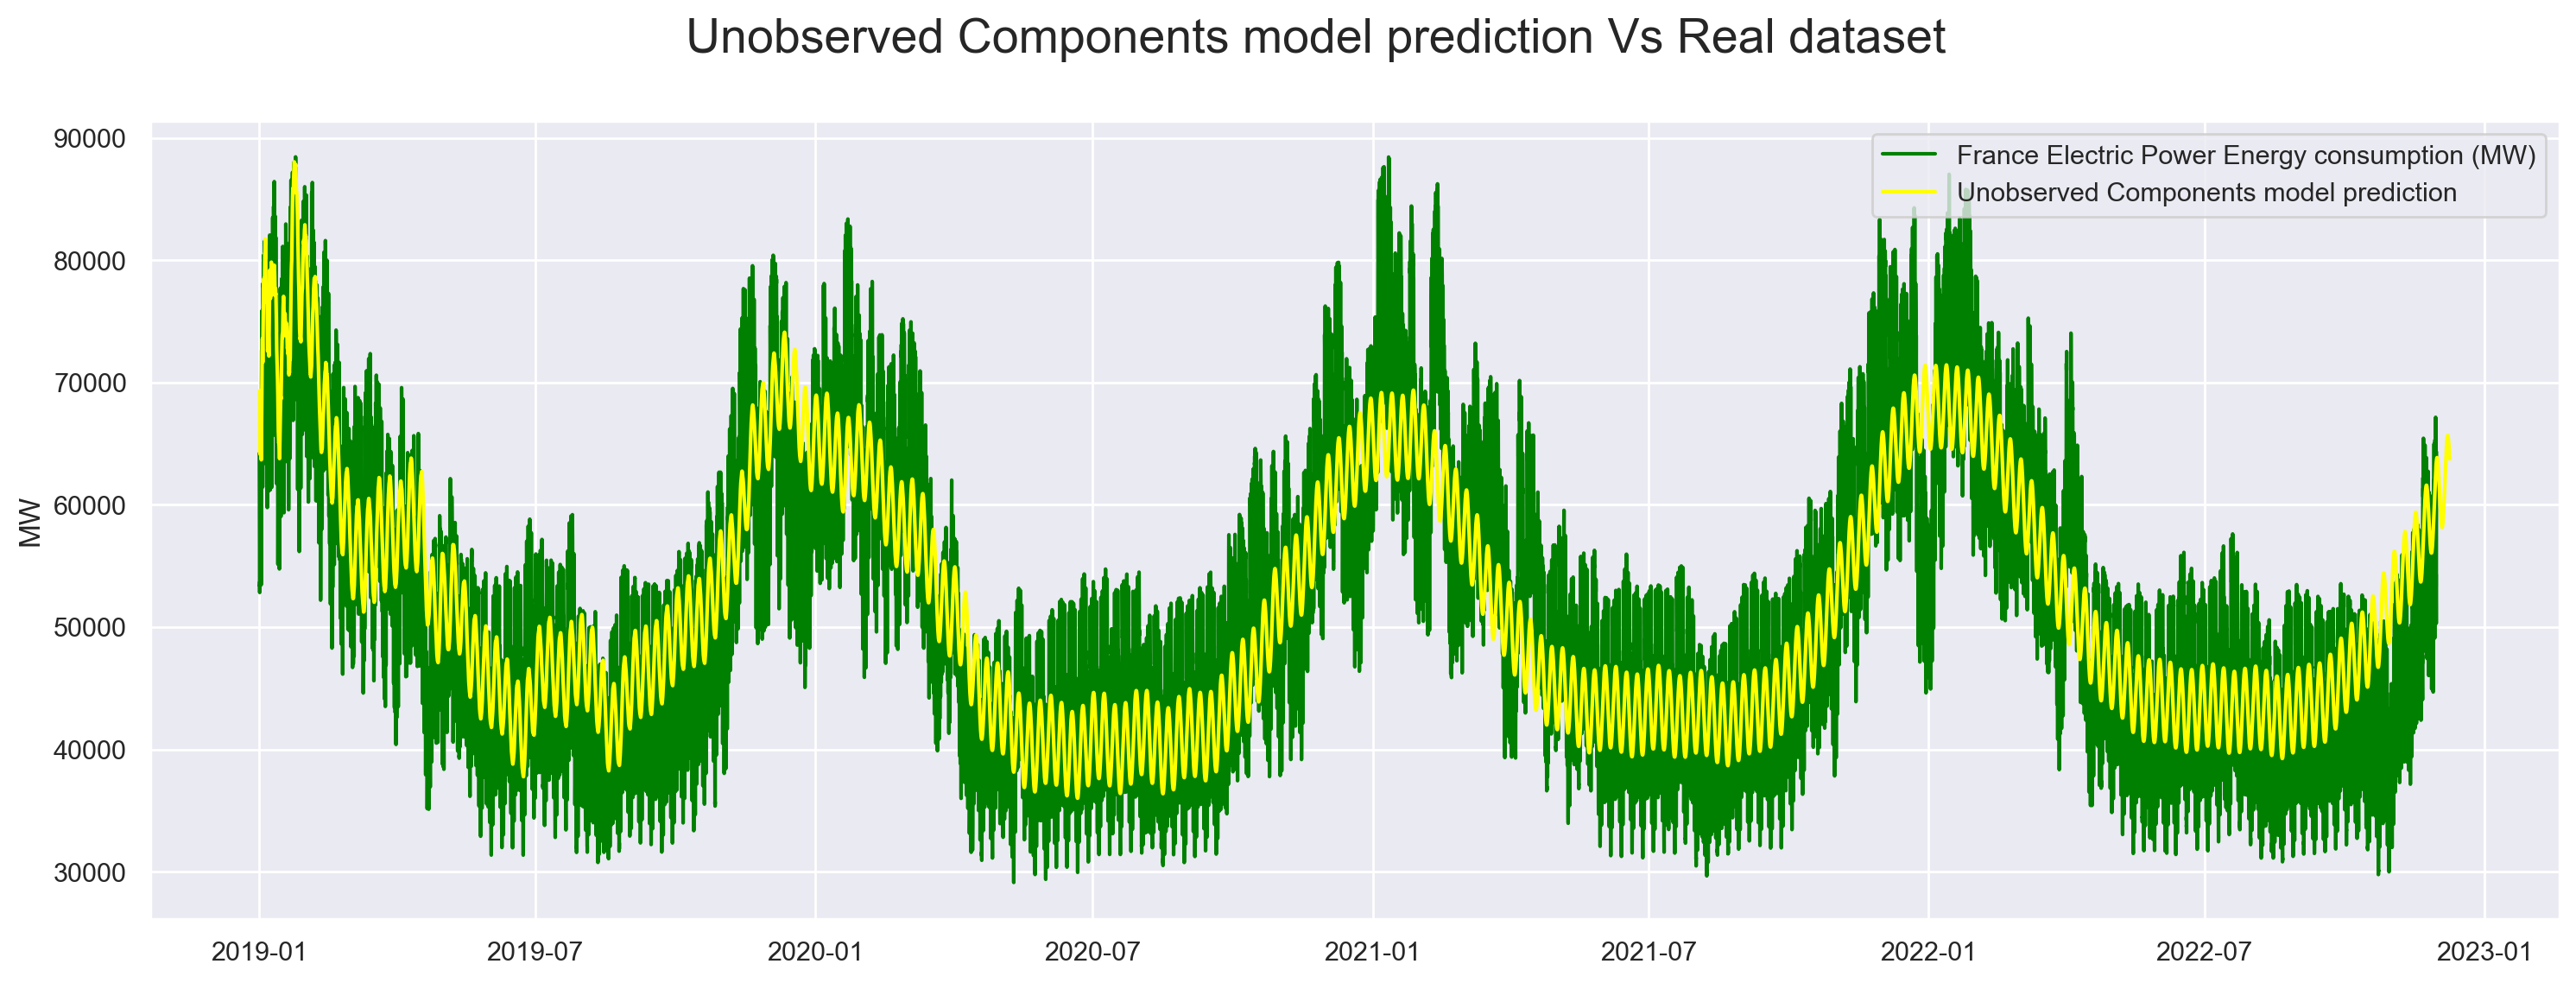

In [14]:
pred = model_UC1res.predict(start="2019-01-01 06:00:00", end="2022-12-08 23:45:00")
f = plt.figure(figsize=(18,6),dpi=200);
#setting title and size of title
plt.suptitle('Unobserved Components model prediction Vs Real dataset', fontsize=20);
#setting y axis label
plt.ylabel('MW');
#plotting the data original 
plt.plot(df, label='France Electric Power Energy consumption (MW)',color='green');
#plotting linear model
plt.plot(pred, label='Unobserved Components model prediction',color='yellow');

plt.legend();


# 2- La prédiction du jour 8 décembre :

In [15]:
#la prédiction du jour 8 décembre 2022
forcast = model_UC1res.predict(start="2022-12-08 00:00:00", end="2022-12-08 23:45:00")
forcast = forcast.to_frame()
forcast.rename(columns = {'predicted_mean':'Solaire (MW)'},inplace = True)
pd.options.display.max_rows = None
forcast

,Solaire (MW)
2022-12-08 00:00:00,65563.579351
2022-12-08 00:15:00,65555.446002
2022-12-08 00:30:00,65547.036181
2022-12-08 00:45:00,65538.350813
2022-12-08 01:00:00,65529.390849
2022-12-08 01:15:00,65520.157265
2022-12-08 01:30:00,65510.651059
2022-12-08 01:45:00,65500.873253
2022-12-08 02:00:00,65490.824892
2022-12-08 02:15:00,65480.507048


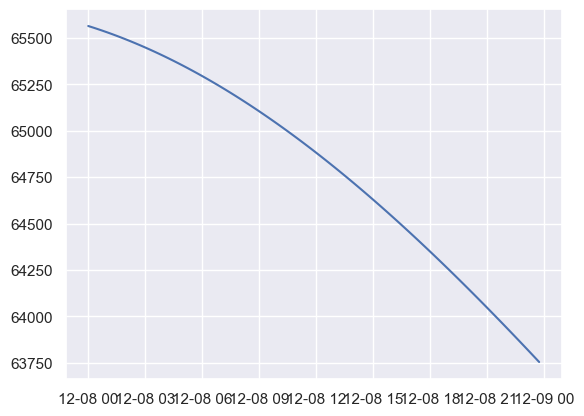

In [16]:
plt.plot(forcast)